<h1 align="center">
<strong>Projet Télédétection Avancée</strong>
</h1>

**Marion BILLY**

**Bretagne 24-25**

# 1. Préparation de l’environnement

### Import des bibliothèques

In [1]:
import sys
import os
from osgeo import gdal
gdal.UseExceptions()
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, train_test_split, GroupShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report

sys.path.append("/home/onyxia/work")
from libsigma import read_and_write as rw
from libsigma import classification as cla
from libsigma import plots

### Définition des chemins

In [2]:
data_path = '/home/onyxia/work/data/projet_eval'
results_path = '/home/onyxia/work/results'
figure_path = '/home/onyxia/work/results/figure'

---

# 2. Analyse des échantillons

## 2.1. Nombre d'échantillons

### 2.1.1 Diagramme en bâton du nombre de polygones par classe

In [4]:
gdf = gpd.read_file(os.path.join(data_path, "PI_strates_bretagne_32630.shp"))
strates = [1, 2, 3, 4]
labels_strates = {1: "Sols Nus", 2: "Herbes", 3: "Landes", 4: "Arbres"}
colors_strates = {1: 'peru', 2: 'goldenrod', 3: 'lightgreen', 4: 'forestgreen'}

# Compter le nombre de polygones par strate
nb_poly = gdf["strate"].value_counts().sort_index()
# Diagramme en bâton
plt.figure()
bars= plt.bar(
    x=[labels_strates[s] for s in nb_poly.index],
    height=nb_poly.values,
    color=[colors_strates[s] for s in nb_poly.index])
# Nombre de polygones au-dessus des barres
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        int(bar.get_height()),
        ha='center',)

plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par strate")
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "diag_baton_nb_poly_by_class.png"), dpi=300)
plt.close()

### 2.1.2 Diagramme en bâton du nombre de pixel par classe

#### Rasterisation

On transforme le shapefile des échantillons en raster. Le raster a la même taille et la même résolution spatiale qu'une image Sentinel-2 de référence. Cela permet ensuite d'extraire facilement avec Numpy le nombre de pixels correspondant à chaque strate.

In [6]:

in_vector = os.path.join(data_path, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(data_path, 'bretagne_24-25_B02.tif') # une image Sentinel-2 de référence
out_image = os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif')
field_name = 'strate'  # attribut contenant les classes numériques

# Infos de l'image de référence
ref_image = rw.open_image(ref_image)
nb_lignes, nb_col, _ = rw.get_image_dimension(ref_image)
origin_x, origin_y = rw.get_origin_coordinates(ref_image)
psize_x, psize_y = rw.get_pixel_size(ref_image)

xmin, xmax = origin_x, origin_x + nb_col * psize_x
ymax, ymin = origin_y, origin_y + nb_lignes * psize_y
sptial_res = abs(psize_x)

print("Spatial resolution :", sptial_res)
print("Extent : xmin =", xmin, "ymin =", ymin, "xmax =", xmax, "ymax =", ymax)

# Rasterisation avec GDAL (terminal)
cmd = (
    f"gdal_rasterize -a {field_name} "
    f"-tr {sptial_res} {sptial_res} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    f"-ot Byte -of GTiff "
    f"{in_vector} {out_image}")
os.system(cmd)

Spatial resolution : 10.0
Extent : xmin = 432950.0 ymin = 5362770.0 xmax = 448280.0 ymax = 5368890.0
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [10]:
roi_raster = os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif')
strates = [1, 2, 3, 4]
labels_strates = {1: "Sols Nus", 2: "Herbes", 3: "Landes", 4: "Arbres"}
colors_strates = {1: 'peru', 2: 'goldenrod', 3: 'lightgreen', 4: 'forestgreen'}

# Extraire X (valeurs des pixels), Y (labels), t (coordonnées)
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)

# Compter le nombre de pixels par classe
classes, counts = np.unique(Y, return_counts=True)
nb_pix = pd.Series(counts, index=classes).sort_index()
# Diagramme en bâton
plt.figure()
bars= plt.bar(
    x=[labels_strates[s] for s in nb_pix.index],
    height=nb_pix.values,
    color=[colors_strates[s] for s in nb_pix.index])
# Nombre de pixels au-dessus des barres
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        int(bar.get_height()),
        ha='center',)
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par strate")
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "diag_baton_nb_pix_by_class.png"), dpi=300)
plt.close()


### 2.1.3 Comparaison des diagrammes et analyse du déséquilibre des strates

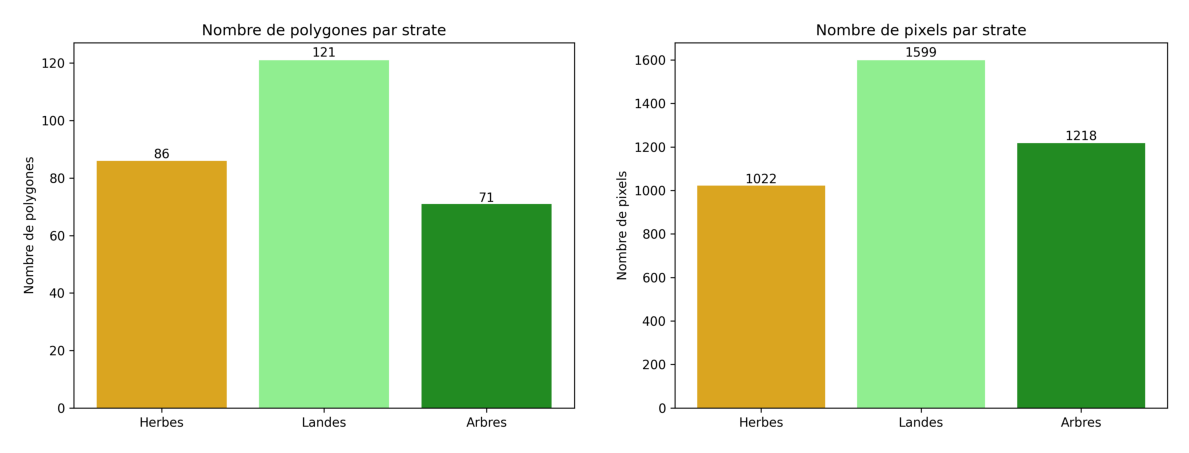

In [11]:
diag_poly = mpimg.imread(os.path.join(figure_path, "diag_baton_nb_poly_by_class.png"))
diag_pix = mpimg.imread(os.path.join(figure_path, "diag_baton_nb_pix_by_class.png"))

# Diagrammes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].imshow(diag_poly)
axes[0].axis('off')
axes[1].imshow(diag_pix)
axes[1].axis('off')
plt.tight_layout()

plt.show()


On observe :
- Une absence de la strate sol nu.
- La strate landes est la plus représentée (121 polygones, 1599 pixels).
- La strate arbres est la 2ᵉ en nombre de pixels, 3ᵉ en nombre de polygones (71 polygones, 1218 pixels).
- La strate herbes est 3ᵉ en nombre de pixels, 2ᵉ en nombre de polygones (86 polygones, 1022 pixels).
Ces diagrammes montrent le déséquilibre des strates, on tiendra compte de cela dans la classification supervisée.

## 2.2. Phénologie des strates, mise en évidence des landes

### 2.2.1 Réorganisation des images Sentinel-2

Les images Sentinel-2 sont fournies sous forme de séries temporelles par bande spectrale : chaque fichier correspond à une bande (B02, B03…) contenant les acquisitions des six dates (mars à août 2025). Pour faciliter les analyses, on crée pour chaque date une image multibande regroupant toutes les bandes spectrales.

In [12]:
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(data_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        single_band = arr[:, :, i]            # extraire la date correspondante
        band_arrays.append(np.atleast_3d(single_band))
    
    # Empiler toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)       # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(data_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(data_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")


Fichier créé pour 2025-03-31 -> /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif
Fichier créé pour 2025-04-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-04-10.tif
Fichier créé pour 2025-05-15 -> /home/onyxia/work/data/projet_eval/bretagne_2025-05-15.tif
Fichier créé pour 2025-06-17 -> /home/onyxia/work/data/projet_eval/bretagne_2025-06-17.tif
Fichier créé pour 2025-07-12 -> /home/onyxia/work/data/projet_eval/bretagne_2025-07-12.tif
Fichier créé pour 2025-08-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-08-10.tif


### 2.2.2 Calcul ARI

L’ARI (Anthocyanin Reflectance Index) est utilisé ici comme indicateur de stress ou de sénescence végétale, permettant de mettre en évidence des différences phénologiques entre strates au cours de la saison de croissance. 
On calcule cet indice à partir des bandes Sentinel-2 B03 (vert) et B05 (red-edge).

In [13]:
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]
ari_list = []

for date in dates:
    filename = os.path.join(data_path, f"bretagne_{date}.tif")
    img = rw.load_img_as_array(filename).astype("float32")

    # Bandes B03 et B05
    b03, b05 = img[:, :, 1], img[:, :, 3]
    # Masque pixels valides, éviter divisions par zéro
    mask_valid = (b03 > 0) & (b05 > 0)
    # Tableau ARI initialisé avec NoData
    ari = np.full(b03.shape, -9999, dtype="float32")
    # Calcul ARI uniquement sur pixels valides
    ari[mask_valid] = (
        (1.0 / b03[mask_valid] - 1.0 / b05[mask_valid]) /
        (1.0 / b03[mask_valid] + 1.0 / b05[mask_valid]))
    # Ajout à la liste pour empilement temporel
    ari_list.append(ari[:, :, np.newaxis])

# Empilement temporel
ari_stack = np.concatenate(ari_list, axis=2)

rw.write_image(
    os.path.join(results_path, "ARI_serie_temp.tif"),
    ari_stack,
    data_set=rw.open_image(os.path.join(data_path, f"bretagne_{dates[0]}.tif")),
    gdal_dtype=gdal.GDT_Float32)

### 2.2.3. Série temporelle, moyenne et écarts types

In [14]:
# Extraire valeurs ARI des pixels d'échantillons
X, Y, _ = cla.get_samples_from_roi(os.path.join(results_path, "ARI_serie_temp.tif"), roi_raster)

# Convertir en DataFrame
df = pd.DataFrame(X, columns=dates)
df['strate'] = Y.flatten()
df.replace(-9999, np.nan, inplace=True)

# Moyenne et écart-type par strate
mean_df = df.groupby('strate').mean()
std_df  = df.groupby('strate').std()

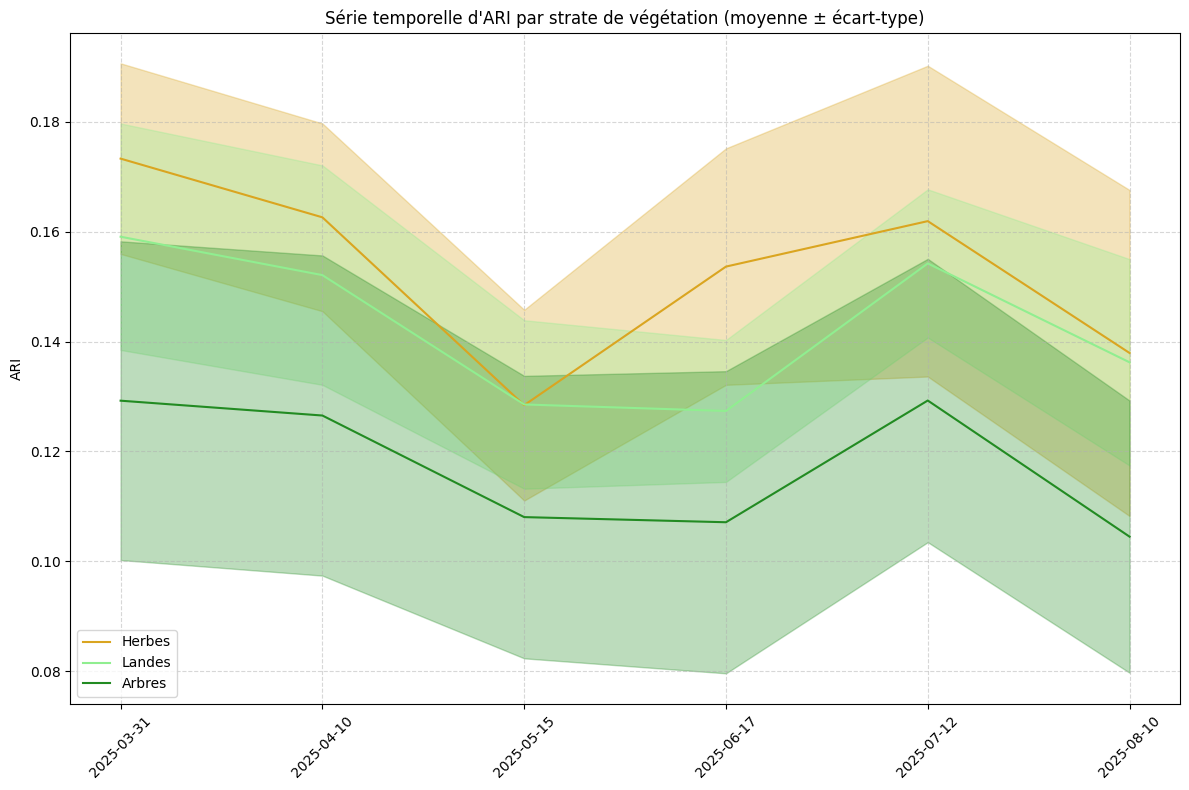

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(dates))

for strate in mean_df.index:
    means = mean_df.loc[strate].values
    stds = std_df.loc[strate].values
    ax.plot(x, means, color=colors_strates[strate], label=labels_strates[strate])
    ax.fill_between(x, means - stds, means + stds, color=colors_strates[strate], alpha=0.3)

ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45)
ax.set_ylabel("ARI")
ax.set_title("Série temporelle d'ARI par strate de végétation (moyenne ± écart-type)")
ax.legend(loc='lower left', frameon=True)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig(os.path.join(figure_path, "ARI_series.png"), dpi=300)
plt.show()


L’évolution de l’indice ARI sur la période étudiée (mars à août) met en évidence les tendances phénologiques des trois strates de végétation. Globalement, les valeurs moyennes suivent l’ordre : Herbes > Landes > Arbres, avec des pics observés en mars et en juillet.

Pour la strate Landes, l’ARI moyen varie entre 0,13 et 0,16, avec une baisse notable en mai-juin avant une remontée en juillet. Les strates Herbes et Landes présentent des valeurs proches et des écarts-types qui se chevauchent. Cela suggère qu’un modèle de classification basé uniquement sur l’ARI pourrait rencontrer des difficultés pour différencier ces deux strates. En revanche, la strate Arbres se distingue plus facilement : son ARI est systématiquement plus faible, ce qui facilite sa séparation des autres strates. 

L’ARI semble être un indicateur limité pour différencier Herbes et Landes.

---

# 3. Production d’une carte de strates à l’échelle du pixel

L’objectif est de produire une carte spatiale des strates de végétation à partir des images Sentinel-2, puis d’évaluer la qualité de la classification à l’aide des échantillons terrain.

## 3.1 Préparation des données
La classification repose sur l’ensemble des bandes spectrales Sentinel-2 disponibles ainsi que sur l’indice ARI calculé pour chaque date d’acquisition. Au total, 11 variables par date sur 6 dates sont utilisées, soit 66 variables explicatives par pixel.
Les images multi-bandes sont empilées sur la dimension spectrale afin de constituer un raster unique servant de base à l’apprentissage et à la prédiction.

In [21]:
stack_list = []

# Liste de toutes les images multibandes par date
for date in dates:
    img_file = os.path.join(data_path, f"bretagne_{date}.tif")
    img = rw.load_img_as_array(img_file)
    stack_list.append(img)

# Ajouter ARI
ari_file = os.path.join(results_path, "ARI_serie_temp.tif")
ari_img = rw.load_img_as_array(ari_file)
stack_list.append(ari_img)

# Concaténation
full_stack = np.dstack(stack_list)  # shape = lignes x colonnes x n_variables
print("Full stack shape:", full_stack.shape)


Full stack shape: (612, 1533, 66)


In [23]:
full_stack_path = os.path.join(results_path, "full_stack.tif")
n_rows, n_cols, n_bands = full_stack.shape

driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(full_stack_path, n_cols, n_rows, n_bands, gdal.GDT_Float32)

origin_x, origin_y = rw.get_origin_coordinates(ref_image)
psize_x, psize_y = rw.get_pixel_size(ref_image)
out_raster.SetGeoTransform([origin_x, psize_x, 0, origin_y, 0, -abs(psize_y)])
out_raster.SetProjection(ref_image.GetProjection())

for i in range(n_bands):
    out_raster.GetRasterBand(i+1).WriteArray(full_stack[:,:,i])

out_raster.FlushCache()
out_raster = None 


Pour éviter que la forte autocorrélation entre pixels d’un même polygone fausse l’évaluation, chaque polygone est rasterisé via son champ id. Ce raster sert à définir des groupes spatiaux pour la validation croisée, garantissant que les pixels d’un même polygone ne sont jamais partagés entre apprentissage et test. Cette stratégie permet d’obtenir des performances réalistes du modèle.

In [24]:
in_vector = os.path.join(data_path, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(data_path, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.join(data_path, 'PI_strates_bretagne_32630_raster_id.tif')
ref_image = rw.open_image(ref_image)
nb_lignes, nb_col, _ = rw.get_image_dimension(ref_image)
origin_x, origin_y = rw.get_origin_coordinates(ref_image)
psize_x, psize_y = rw.get_pixel_size(ref_image)

xmin, xmax = origin_x, origin_x + nb_col * psize_x
ymax, ymin = origin_y, origin_y + nb_lignes * psize_y
sptial_res = abs(psize_x)

print("Spatial resolution :", sptial_res)
print("Extent : xmin =", xmin, "ymin =", ymin, "xmax =", xmax, "ymax =", ymax)

# Rasterisation avec GDAL (terminal) sur le champ 'id'
cmd = (
    f"gdal_rasterize -a id " 
    f"-tr {sptial_res} {sptial_res} "
    f"-te {xmin} {ymin} {xmax} {ymax} "
    f"-ot Int32 -of GTiff "
    f"{in_vector} {out_image}")
os.system(cmd)

Spatial resolution : 10.0
Extent : xmin = 432950.0 ymin = 5362770.0 xmax = 448280.0 ymax = 5368890.0
0...10...20...30...40...50...60...70...80...90...100 - done.


0

## 3.2. Choix du classifieur et sa paramètrisation

Pour la classification supervisée des strates, nous utilisons RandomForestClassifier de scikit-learn.

Le jeu de données est divisé en sous-ensembles test / train selon un ratio 70/30, comme vu en TD.

Les échantillons sont extraits à partir du raster empilé (variables spectrales par pixel) et du raster des polygones terrain (classes de strates et identifiants des polygones). Les pixels appartenant à un même polygone peuvent être fortement corrélés, ce qui fausserait l’évaluation si l’on utilisait une validation classique. Pour éviter cela, les données sont séparées par groupes (un groupe par polygone) avec StratifiedGroupKFold, ce qui garantit que les pixels d’un polygone donné n’apparaissent jamais à la fois dans l’apprentissage et dans le test. *Un essai sans cette séparation a conduit à un score irréaliste de 0,97.*

Les hyperparamètres du Random Forest (nombre d’arbres, profondeur maximale, nombre de variables à chaque split, nombre minimum d’échantillons par feuille) sont optimisés via GridSearchCV combiné à StratifiedGroupKFold. Le déséquilibre des classes est pris en compte en utilisant la métrique F1-weighted pour l’optimisation, au lieu de l’accuracy.

Cette approche permet d’obtenir un modèle robuste. Le meilleur modèle présente un F1-weighted moyen en CV de 0,902, avec un écart-type de 0,038. Les meilleurs hyperparamètres sont : max_depth=15, max_features='sqrt', min_samples_leaf=1, n_estimators=100.

In [25]:
# Extraire X, y et groupes
full_stack = os.path.join(results_path, "full_stack.tif")
X, y, _ = cla.get_samples_from_roi(full_stack, os.path.join(data_path, 'PI_strates_bretagne_32630_raster.tif'))
_, groups, _ = cla.get_samples_from_roi(full_stack, out_image)
y = np.ravel(y)
groups = np.ravel(groups)

print("X :", X.shape, "y :", y.shape, "groups :", groups.shape)

X : (3839, 66) y : (3839,) groups : (3839,)


In [27]:
# Split train/test par polygone
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(gss.split(X, y, groups=groups)) # groups contient l'ID du polygone pour chaque pixel

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

print(f"Train pixels : {X_train.shape[0]}, Test pixels : {X_test.shape[0]}")
print(f"Train groups : {len(np.unique(groups_train))}, Test groups : {len(np.unique(groups_test))}")

Train pixels : 2676, Test pixels : 1163
Train groups : 67, Test groups : 30


## 3.3. Stratégie de validation

In [28]:
# Définir le classifieur et la grille d'hyperparamètres
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5]}

# StratifiedGroupKFold sur le train
cv = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=0)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,
    return_train_score=True)

# Optimisation
grid_search.fit(X_train, y_train, groups=groups_train) 
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur F1-weighted CV :", grid_search.best_score_)


Meilleurs hyperparamètres : {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Meilleur F1-weighted CV : 0.902104095367578


In [29]:
# Score moyen CV
print(f"Score CV moyen : {grid_search.best_score_:.3f}")
print(f"Écart-type CV du meilleur modèle : {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.3f}")

Score CV moyen : 0.902
Écart-type CV du meilleur modèle : 0.038


In [30]:
# Evaluation sur le test set
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score test : {f1:.3f}")

F1-score test : 0.887


L'application du meilleur modèle sur le jeu de test (les 30% de pixels gardés isolés dès le début) donne une précision globale de 0.887. Ce score est proche de celui obtenu lors de la validation croisée (0.902).

Matrice de confusion

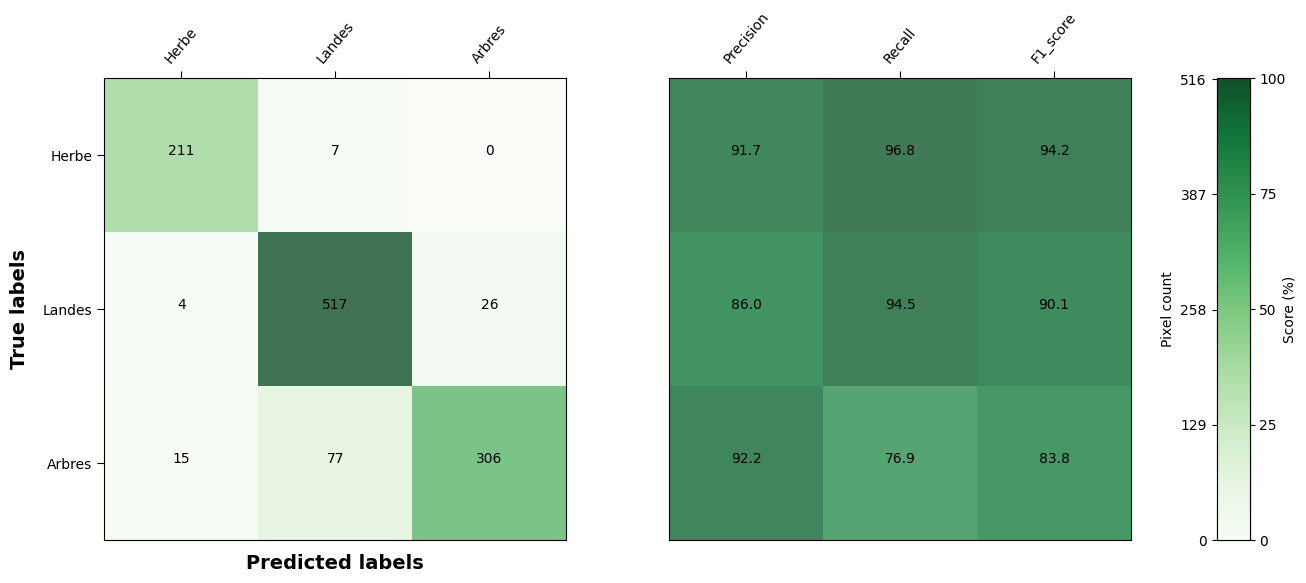

In [31]:
cm = confusion_matrix(y_test, y_pred)
plots.plot_cm(cm, labels=['Herbe', 'Landes', 'Arbres'])

La matrice de confusion présente les classes observées en lignes et les classes prédites en colonnes : Herbe, Landes et Arbres. Elle montre une bonne classification globale, avec la majorité des pixels correctement classés sur la diagonale.

- Herbes : F1-score de 94,2 %, rappel et précision élevés, ce qui en fait la classe la mieux détectée.
- Landes : F1-score de 90,1 %. Quelques pixels sont mal classés, notamment 26 pixels prédits comme Arbres. La classe a un bon rappel (94,5 %) mais une précision plus faible (86 %), ce qui signifie que la plupart des pixels de landes sont correctement identifiés, mais certains pixels prédits comme Landes appartiennent en réalité à une autre classe (Arbres).
- Arbres : F1-score de 83,8 %. 77 pixels sont confondus avec les Landes et 17 avec les Herbes. La précision est bonne (92,2 %) mais le rappel est plus faible (76,9 %), indiquant que certains pixels Arbres sont prédits à tort comme Landes.

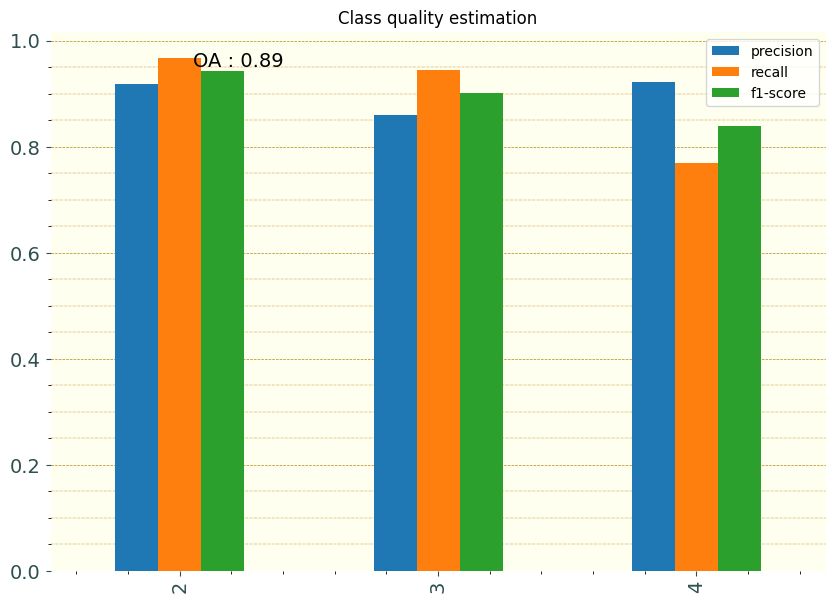

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
accuracy = (y_test == y_pred).mean() 
plots.plot_class_quality(report, accuracy)

Le graphique présente l’estimation de la qualité par classe (précision, rappel et F1-score). Comme le montre la matrice de confusion, les valeurs sont globalement élevées pour toutes les classes, confirmant la bonne performance du modèle de classification, avec une Overall Accuracy de 0,89.

La classe Herbe affiche les meilleures valeurs. La classe Landes présente des valeurs légèrement inférieures, notamment au niveau de la précision. La classe Arbre a un rappel et un F1-score plus faibles que les deux autres classes, en accord avec les confusions observées dans la matrice de confusion (des arbres prédits comme landes ou herbes).

## 3.4. Contribution des variables

In [35]:
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Contribution des variables
df_contributions = pd.DataFrame({
    "feature": [f"{band}_{date}" for date in dates for band in band_names] + [f"ARI_{date}" for date in dates],
    "contribution": best_model.feature_importances_
})

# Trier par contribution décroissante
df_contributions.sort_values("contribution", ascending=False, inplace=True)

In [36]:
sentinel_colors = {
    "B02": "#7fbbff",
    "B03": "#7fff7f",
    "B04": "#ff7f7f",
    "B05": "#cce6ff",
    "B06": "#8f9779",
    "B07": "#ffccff",
    "B08": "#bf4040",
    "B8A": "#ff9966",
    "B11": "#d1b280",
    "B12": "#b399c2",
    "ARI": "#e6c800" }

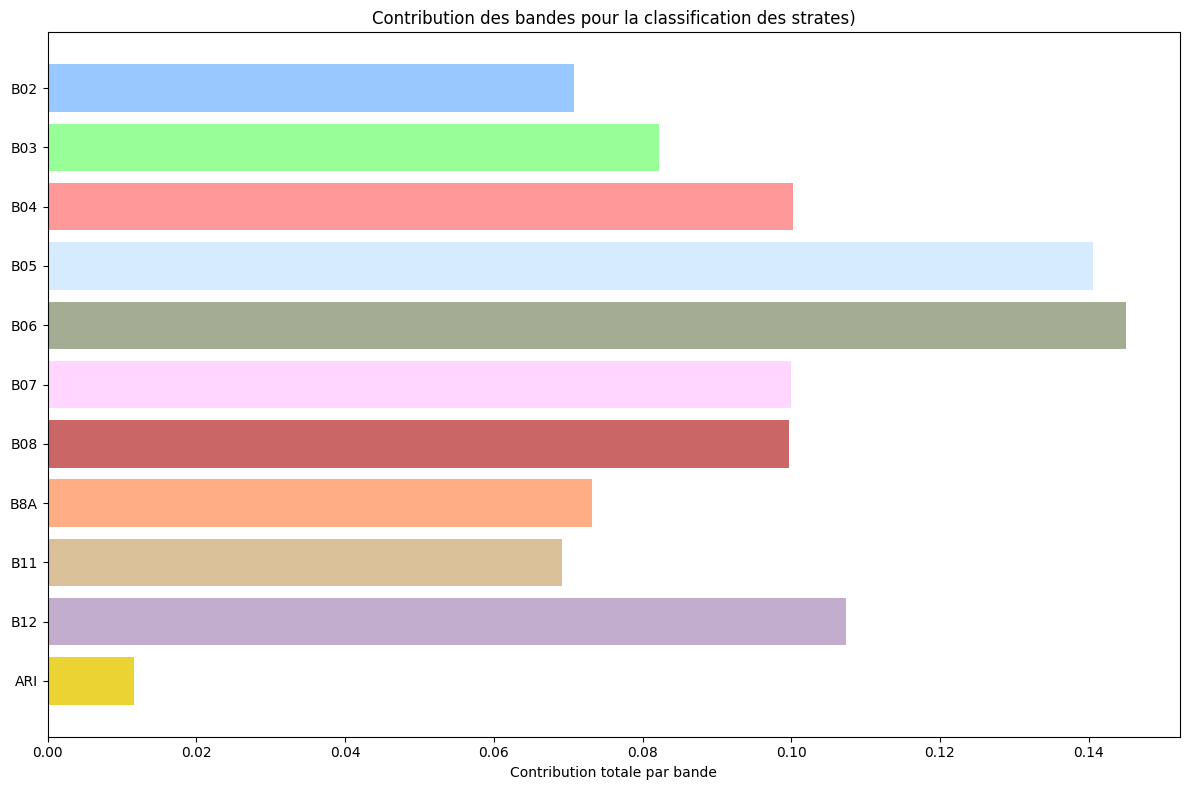

In [37]:
df_contributions["band"] = df_contributions["feature"].apply(lambda x: x.split("_")[0])
df_band = df_contributions.groupby("band")["contribution"].sum().reset_index()

band_order = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","ARI"]
df_band["band"] = pd.Categorical(df_band["band"], categories=band_order, ordered=True)
df_band = df_band.sort_values("band")

plt.figure(figsize=(12,8))
plt.barh(
    df_band["band"],
    df_band["contribution"],
    color=df_band["band"].map(sentinel_colors),
    alpha=0.8)
plt.xlabel("Contribution totale par bande")
plt.title("Contribution des bandes pour la classification des strates)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()



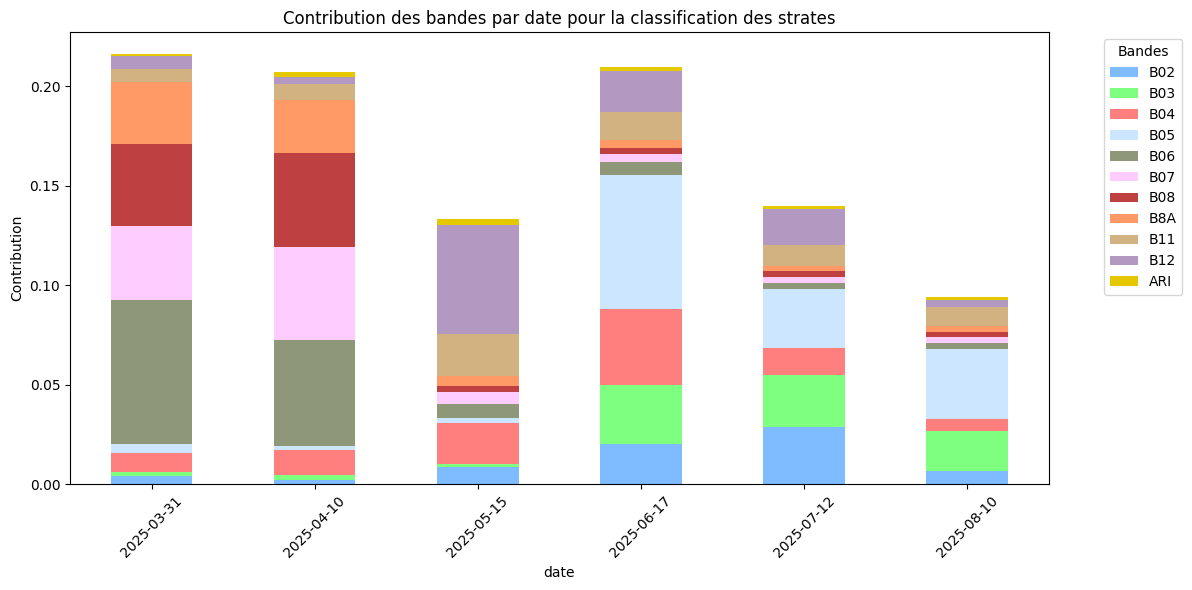

In [40]:
df_contributions["date"] = df_contributions["feature"].apply(lambda x: x.split("_")[1])
pivot_df = df_contributions.pivot_table(index="date", columns="band", values="contribution", aggfunc="sum")
pivot_df = pivot_df.reindex(columns=band_order)
colors = [sentinel_colors[b] for b in pivot_df.columns]

pivot_df.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6), 
    color=colors)
plt.ylabel("Contribution")
plt.title("Contribution des bandes par date pour la classification des strates")
plt.xticks(rotation=45)
plt.legend(title="Bandes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Les variables les plus contributives au modèle sont principalement des bandes Sentinel‑2 liées à la végétation. Les contributions les plus élevées (supérieures à 0.10) sont respectivement, B06, B05, B12, B04, B07 et B08. L’ARI apparaît comme quasiment non contributif.
Sur le plan temporel, les mois ui contribuent le plus pour la classification sont mars, avril et juin, indiquant que ces périodes fournissent les informations spectrales les plus pertinentes pour distinguer les strates.

---

# 4. Production des cartes finales

La classification a été appliquée à l’ensemble des pixels de l’image empilée.

In [41]:
# --- Chemins ---
full_stack_path = os.path.join(results_path, "full_stack.tif")
carte_file = os.path.join(results_path, "carte_strates.tif")

# --- Charger le stack ---
array_stack = rw.load_img_as_array(full_stack_path)  # rows x cols x bands
n_rows, n_cols, n_features = array_stack.shape

# --- Préparer les données ---
X_pred = array_stack.reshape(-1, n_features)
X_pred = np.nan_to_num(X_pred, nan=-9999)

# --- Prédiction ---
y_pred_flat = best_model.predict(X_pred)
y_pred_raster = y_pred_flat.reshape(n_rows, n_cols)

# --- Ouvrir le raster de référence pour le masque ---
ds_ref = rw.open_image(full_stack_path)
ref_data = ds_ref.GetRasterBand(1).ReadAsArray()

# --- Gestion NoData ---
nodata_val = -9999
y_pred_raster[np.isnan(ref_data)] = nodata_val
y_pred_raster = y_pred_raster.astype(np.int16)

# --- Écriture ---
rw.write_image(
    carte_file,
    y_pred_raster,
    data_set=ds_ref,
    gdal_dtype=gdal.GDT_Int16
)

# --- Définir le NoData après écriture ---
ds_out = rw.open_image(carte_file, mode="update")
band = ds_out.GetRasterBand(1)
band.SetNoDataValue(nodata_val)
ds_out = None
ds_ref = None


---

# 5. Analyse des résultats

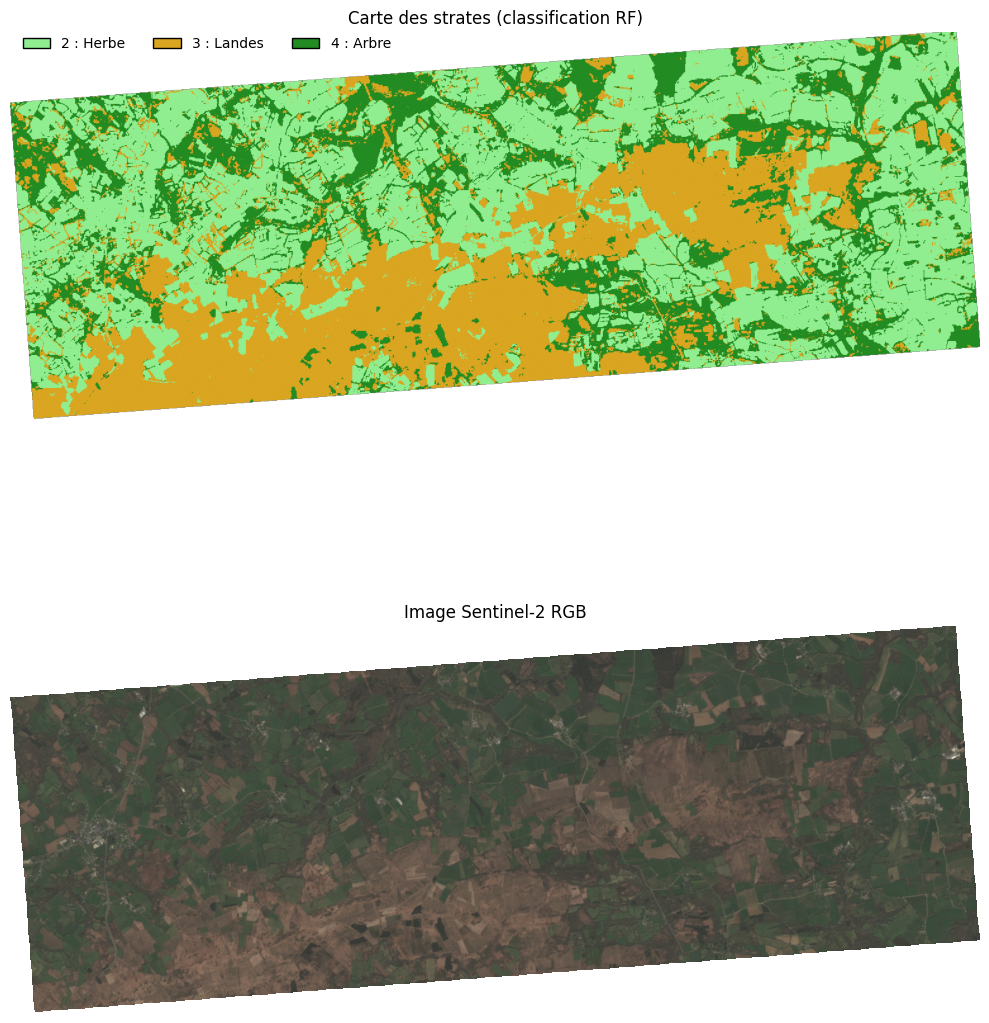

In [42]:
# Indices des bandes dans le stack 
idx_B02 = band_order.index("B02")
idx_B03 = band_order.index("B03")
idx_B04 = band_order.index("B04")

# Construire le RGB
rgb = np.dstack((
    array_stack[:, :, idx_B04],
    array_stack[:, :, idx_B03],
    array_stack[:, :, idx_B02]))
rgb = rgb.astype(float)
rgb /= np.nanmax(rgb)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Carte de classification

classes = [2, 3, 4]
labels = ['Herbe', 'Landes', 'Arbre']
colors = ['lightgreen', 'goldenrod', 'forestgreen']

cmap = ListedColormap(colors)
norm = BoundaryNorm([1.5, 2.5, 3.5, 4.5], cmap.N)

masked_raster = np.ma.masked_equal(y_pred_raster, nodata_val)

axes[0].imshow(masked_raster, cmap=cmap, norm=norm)
axes[0].set_title("Carte des strates (classification RF)")
axes[0].axis("off")

legend_elements = [
    Patch(facecolor=colors[i], edgecolor='black',
          label=f"{classes[i]} : {labels[i]}")
    for i in range(len(classes))
]

axes[0].legend(
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(0, 1.02),
    ncol=3,
    frameon=False
)

# Image RGB

axes[1].imshow(rgb)
axes[1].set_title("Image Sentinel-2 RGB")
axes[1].axis("off")

plt.tight_layout()
plt.subplots_adjust(hspace=0.03)
plt.show()


La carte finale de classification montre une identification claire des trois strates. La fragmentation des landes observée reflète leur nature intermédiaire (entre herbes et arbres). La stratification spatiale identifiée est cohérente avec les observations terrain (sur QGIS), ce qui valide la méthode employée.

## Discussion

### Limites
La résolution spatiale de 10 mètres des images Sentinel-2 peut entraîner un mélange de pixels situés à la frontière entre deux strates, ce qui génère des erreurs de classification. Aussi, la série temporelle utilisée est limitée à seulement six dates comprises entre mars et août, ce qui peut masquer certaines variations phénologiques.

### Perspectives et améliorations
L’ARI se révèle insuffisant pour discriminer nos classes, et l’utilisation d’autres indices comme que le NDVI pourrait améliorer la distinction. Une augmentation de la résolution temporelle, avec des acquisitions d’images plus fréquentes et sur une période plus longue pourrait être bénéfique. On peut imaginer que l’extension de cette approche à d’autres régions constituerait un moyen d’évaluer la robustesse du modèle.

### Conclusion 
Le modèle Random Forest, combiné à une stratégie de validation par polygones, fournit une classification robuste et réaliste des strates de végétation. Les bandes Sentinel-2 suffisent pour identifier les principales strates, tandis que l’ARI présente une utilité limitée. Ces résultats confirment la pertinence d’une approche intégrant données multibandes et séries temporelles.


____

## Diagramme de flux

![Diagramme de flux](/home/onyxia/work/projet_telea_landes/img/Diagrammedeflux_telea.png)
